# Import library

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# 배경색 흰색으로 맞춰줌
import matplotlib as mpl
mpl.rc('figure', facecolor = 'w', edgecolor ='w')

# Preprocessing

### Load Data

In [2]:
# Data Load
demo = pd.read_csv('../data/LPOINT_BIG_COMP_01_DEMO.csv', low_memory=False)
pdde = pd.read_csv('../data/LPOINT_BIG_COMP_02_PDDE.csv', low_memory=False)
cop = pd.read_csv('../data/LPOINT_BIG_COMP_03_COP_U.csv', low_memory=False)
clac = pd.read_csv('../data/LPOINT_BIG_COMP_04_PD_CLAC.csv', low_memory=False)
br = pd.read_csv('../data/LPOINT_BIG_COMP_05_BR.csv', low_memory=False)
lpay = pd.read_csv('../data/LPOINT_BIG_COMP_06_LPAY.csv', low_memory=False)

# Column명 변경
demo.columns = ['고객번호', '성별', '연령대', '거주지대분류코드']
pdde.columns = ['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '구매시간', '구매금액', '구매수량']
cop.columns = ['고객번호', '영수증번호', '제휴사', '점포코드', '채널구분', '이용일자', '방문일자', '이용시간', '이용금액']
clac.columns = ['상품코드', '소분류명', '대분류명', '중분류명']
br.columns = ['점포코드', '제휴사', '점포대분류코드', '점포중분류코드']
lpay.columns = ['고객번호', '영수증번호', '제휴사', '채널구분', '이용일자', '이용시간', '이용금액']

### Data Preprocessing

- 가독성을 위하여 불필요한 데이터 확인과정 삭제

####  [2. pdde]: 상품 구매 정보

In [3]:
# 중복되는 행 제거 -> 데이터 추출시 고객, 상품 각각 추출하여 중복이 발생한 것으로 판단함
pdde.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)

# 결측치 치환 -> na값을 온라인으로 채워줌
pdde['점포코드'] = pdde['점포코드'].fillna('온라인')

#### [3. cop]: 제휴사 이용 정보

In [4]:
# 결측치 치환
cop['점포코드'] = cop['점포코드'].fillna('온라인')

# Data Merge

In [5]:
# 데이터를 통합하기 위하여 칼럼 통합
pdde['타입'] = 'Product'
cop['타입'] = 'Affiliate'
lpay['타입'] = 'Lpay'
pdde['방문일자'] = 0
lpay['방문일자'] = 0
cop['구매수량'] = 0
cop['상품코드'] = np.nan
lpay['점포코드'] = np.nan
lpay['상품코드'] = np.nan
lpay['구매수량'] = 0

In [6]:
# 칼럼명을 새롭게 동일하게 통일
cop.columns = ['고객번호', '영수증번호', '제휴사', '점포코드', '채널구분', '구매일자', '방문일자', '구매시간', '구매금액', '타입', '구매수량', '상품코드']
lpay.columns = ['고객번호', '영수증번호', '제휴사', '채널구분', '구매일자', '구매시간', '구매금액', '타입', '방문일자', '점포코드', '상품코드', '구매수량']

# 상품구매데이터를 기준으로 하여 열을 통일
cop = cop[['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '방문일자', '구매시간', '구매금액', '구매수량', '타입']]
lpay = lpay[['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '방문일자', '구매시간', '구매금액', '구매수량', '타입']]

# 데이터 타입 변경
lpay['영수증번호'] = lpay['영수증번호'].astype('object')
lpay['점포코드'] = lpay['점포코드'].astype('object')
cop['상품코드'] = cop['상품코드'].astype('object')
lpay['상품코드'] = lpay['상품코드'].astype('object')
pdde['구매금액'] = pdde['구매금액'].astype('int')
pdde['방문일자'] = pdde['방문일자'].astype('int64')
lpay['방문일자'] = lpay['방문일자'].astype('int64')

In [7]:
# 데이터 concat
df = pd.concat([pdde,cop,lpay])
# 고객 정보 테이븛 통합
df = pd.merge(df, demo, on = ['고객번호'], how = 'left')
# 상품 분류 테이블 통합
df = pd.merge(df, br, on = ['점포코드','제휴사'], how = 'left')
# 점포 정보 테이블 통합
df = pd.merge(df, clac, on = ['상품코드'], how = 'left')

In [8]:
# 결측치 확인 -> 데이터를 합치면서 생기는 결측치만 존재
df.isnull().sum()

고객번호             0
영수증번호            0
채널구분             0
제휴사              0
점포코드        353184
상품코드        601488
구매일자             0
구매시간             0
구매금액             0
구매수량             0
타입               0
방문일자             0
성별               0
연령대              0
거주지대분류코드         0
점포대분류코드     729023
점포중분류코드     729023
소분류명        601488
대분류명        601488
중분류명        601488
dtype: int64

## Train Test Split

In [9]:
# 날짜로 변경
df['날짜'] = df['구매일자'].astype(str)
df['날짜'] = pd.to_datetime(df['날짜'])
# 각 거래일간의 차이를 구함
df = df.sort_values(by=['날짜'], ascending=[True])
df['diff'] = df.groupby('고객번호')['날짜'].diff().fillna('0').astype(str)
df['diff'] = df['diff'].apply(lambda x: int(x.split()[0]))
# 데이터를 거래횟수별로 나누기 위한 작업
trans = df.groupby('고객번호')['영수증번호'].apply(set).reset_index()
trans['거래횟수'] = trans['영수증번호'].apply(lambda x:len(list(x)))
# 뉴비와 올드비를 구분해줌
oldbie = trans[trans['거래횟수']>3]['고객번호'].tolist()
newbie = trans[trans['거래횟수']<=3]['고객번호'].tolist()

# 데이터 분리
df_old = df[df['고객번호'].isin(oldbie)]
df_new = df[df['고객번호'].isin(newbie)]

## 이탈 위험율 예측

#### 최종 접속 경과일 (최종 구매 경과일)

In [76]:
imp = df.sort_values(by=['날짜'], ascending=[True]).groupby(['고객번호', '날짜'])[['채널구분']].count().reset_index().groupby('고객번호')['날짜'].agg([('구매일수', 'count')]).reset_index()
# 딱 하루만 구매한 고객들
oneday_buyer = list(imp[imp['구매일수']==1]['고객번호'])
# 고객별 구매 날짜
imp2 = df.groupby(['고객번호', '날짜'])[['채널구분']].count().drop('채널구분', axis=1).reset_index()
# 최근 구매일자별 최근 상위 2개를 구함
result = imp2.sort_values(by=['고객번호', '날짜']).groupby('고객번호')['날짜'].apply(set).reset_index()
result['최근상위2'] = result['날짜'].apply(lambda x:sorted(list(x))[-2:])
# 상위 두일자의 차이를 구한 후 빼줌
result['최종구매경과일'] = result['최근상위2'].apply(lambda x: abs(x[1] - x[0]) if len(x) == 2 else abs(pd.to_datetime('2021-12-31') - x[0]))
# int로 변환
result['최종구매경과일'] = result['최종구매경과일'].dt.days
# 결과 도출
result = result[['고객번호','최종구매경과일']];result

,고객번호,최종구매경과일
0,M000034966,54
1,M000059535,303
2,M000136117,14
3,M000201112,107
4,M000225114,6
...,...,...
29869,M999708287,58
29870,M999770689,13
29871,M999849895,47
29872,M999926092,76


#### 평균 구매일 주기

In [77]:
diff_final_buy = df.groupby('고객번호')['날짜'].diff().fillna('0').astype(str)
diff_final_buy = diff_final_buy.apply(lambda x: abs(int(x.split()[0])))
df['diff'] = diff_final_buy
f = df.groupby(['고객번호'])[['diff']].sum().reset_index()
result['구매간격합'] = f['diff']
result['구매일수'] = imp['구매일수']
result['구매접속간격'] = result['구매일수']-1

In [78]:
# 평균구매주기
mean_buy_cycle = [] 

for i in range(result.shape[0]):
    try:
        mean_buy_cycle.append(result['구매간격합'][i]/result['구매접속간격'][i])

    except ZeroDivisionError:
        mean_buy_cycle.append(1)
        continue

len(mean_buy_cycle)

<ipython-input-78-472f402cf1fe>:6: RuntimeWarning: invalid value encountered in longlong_scalars
  mean_buy_cycle.append(result['구매간격합'][i]/result['구매접속간격'][i])


29874

In [79]:
result['평균구매주기'] = mean_buy_cycle
# 딱 하루 구매한 사람들은 평균구매주기를 1로 대체
result['평균구매주기'].fillna(1, inplace=True)

#### 이탈 위험 비율
- [최종구매경과일] / [평균구매주기]

In [80]:
result['이탈위험비율'] = result['최종구매경과일']/result['평균구매주기']

In [81]:
churn = result[['고객번호', '이탈위험비율']]

# RFM

In [16]:
customer_id = df_old.groupby('고객번호')[['구매일자']].max().index.tolist()
recency = df_old.groupby('고객번호')[['구매일자']].max()['구매일자'].tolist()
freq = df_old.groupby('고객번호')['영수증번호'].apply(set).reset_index()
frequency = freq['영수증번호'].apply(lambda x:len(list(x)))
monetary = df_old.groupby('고객번호')[['구매금액']].sum()['구매금액'].tolist()

df_rfm = pd.DataFrame({'Customer_ID': customer_id, 'Recency': recency, 'Frequency': frequency, 'Monetary': monetary})

In [17]:
df_rfm['Recency'] = df_rfm['Recency'].astype(str)
df_rfm['Recency'] = pd.to_datetime(df_rfm['Recency'])
df_rfm['Recency'] = df_rfm['Recency'] - pd.to_datetime('20210101')
# df_rfm['Recency'] = [x.total_seconds() for x in df_rfm['Recency']]

df_rfm['Recency'] = df_rfm['Recency'].dt.days # days로
df_rfm

,Customer_ID,Recency,Frequency,Monetary
0,M000034966,356,13,616240
1,M000136117,363,89,28697031
2,M000201112,331,5,51420
3,M000225114,364,88,2084270
4,M000261625,337,49,6072050
...,...,...,...,...
26207,M999673157,351,17,2851370
26208,M999770689,364,216,2078770
26209,M999849895,334,35,1095312
26210,M999926092,335,7,129500


# Data Clustering

- k-means를 위한 Scaling

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
import time
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D

In [19]:
scaler = StandardScaler()
scaler.fit(df_rfm.iloc[:,1:])

StandardScaler()

In [20]:
rfm_scaled = scaler.transform(df_rfm.iloc[:,1:]) 

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns = df_rfm.iloc[:,1:].columns) 
rfm_scaled_df.insert(0, 'Customer_ID', df_rfm['Customer_ID'])
rfm_scaled_df

,Customer_ID,Recency,Frequency,Monetary
0,M000034966,0.388787,-0.682454,-0.292294
1,M000136117,0.549046,0.211318,1.677066
2,M000201112,-0.183566,-0.776535,-0.331906
3,M000225114,0.571940,0.199558,-0.189339
4,M000261625,-0.046201,-0.259088,0.090332
...,...,...,...,...
26207,M999673157,0.274316,-0.635413,-0.135540
26208,M999770689,0.571940,1.704857,-0.189724
26209,M999849895,-0.114884,-0.423730,-0.258696
26210,M999926092,-0.091990,-0.753015,-0.326430


- Clustering

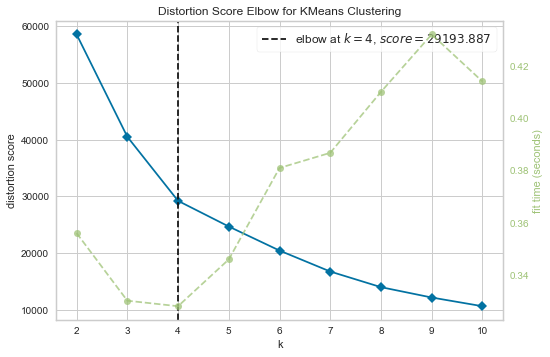

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
kmeans = KMeans(random_state=np.random.RandomState(seed=42))

elb_visualizer = KElbowVisualizer(kmeans, k=(2,11))
elb_visualizer.fit(rfm_scaled_df.iloc[:,1:])
elb_visualizer.show()

- 실루엣 계수 확인

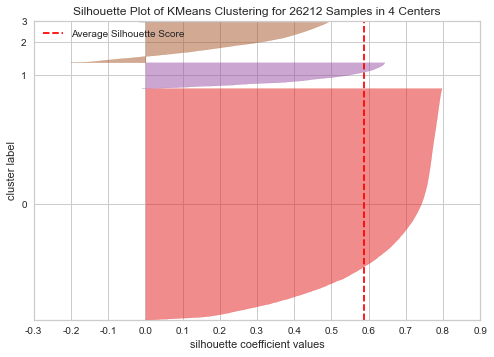

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 26212 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [22]:
model_4clust = KMeans(n_clusters = 4, random_state=np.random.RandomState(seed=42))

sil_visualizer = SilhouetteVisualizer(model_4clust)
sil_visualizer.fit(rfm_scaled_df.iloc[:,1:])
sil_visualizer.show()

- 군집 라벨링

In [23]:
kmeans = KMeans(n_clusters = 4, random_state=np.random.RandomState(seed=42))
labels = kmeans.fit_predict(rfm_scaled_df.iloc[:,1:])

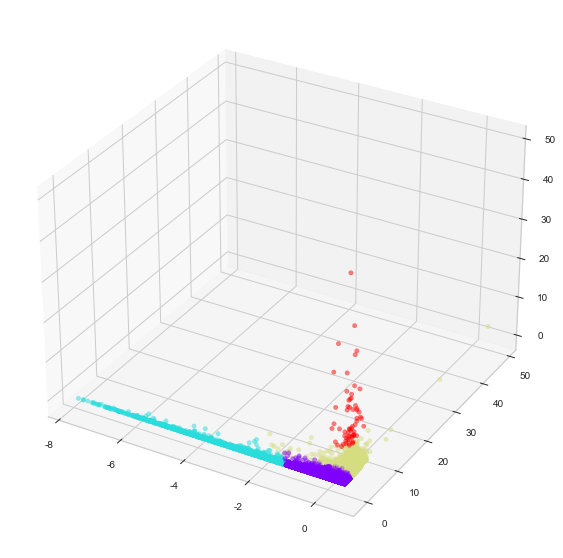

In [24]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = rfm_scaled_df['Recency']
y = rfm_scaled_df['Frequency']
z = rfm_scaled_df['Monetary']
ax.scatter(x, y, z, c = labels, s= 20, alpha=0.5, cmap='rainbow')

## 이상치 대체 후 시각화
    - 별다른 소득 없음

In [26]:
# # 이상치 제거해봄
# def outlier(data):
#     q25,q75  = data.quantile(0.25), data.quantile(0.75)
#     iqr = q75 - q25
#     cut_off = iqr*1.5
#     lower, upper = q25-cut_off, q75+cut_off
#     # 이상치는 최대 혹은 최소값으로 대체
#     data[lower > data] = lower
#     data[data > upper] = upper
#     return data

# # 이상치 제거한 데이터 생성, 후처리
# remove_outlier = pd.DataFrame(outlier(rfm_scaled_df['Recency']))
# remove_outlier['Frequency'] = outlier(rfm_scaled_df['Frequency'])
# remove_outlier['Monetary'] = outlier(rfm_scaled_df['Monetary'])

# remove_outlier.insert(0,'Customer_ID',rfm_scaled_df['Customer_ID'],allow_duplicates=True)
# remove_outlier.insert(len(remove_outlier.columns),'labels',rfm_scaled_df['labels'],allow_duplicates=True)

In [27]:
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d') 

# x = remove_outlier['Recency']
# y = remove_outlier['Frequency']
# z = remove_outlier['Monetary']
# ax.scatter(x, y, z, c = labels, s= 5, alpha=0.5, cmap='rainbow',marker ='^')

In [28]:
rfm_scaled_df['labels'] = labels
rfm_df = rfm_scaled_df[['Customer_ID', 'labels']]
rfm_df.columns = ['고객번호', 'labels']
rfm_df.head(3)

,고객번호,labels
0,M000034966,0
1,M000136117,2
2,M000201112,0


- data merge

In [29]:
df_old = pd.merge(df_old, rfm_df, on = ['고객번호'], how = 'left')
df_old.head(3)

,고객번호,영수증번호,채널구분,제휴사,점포코드,상품코드,구매일자,구매시간,구매금액,구매수량,...,연령대,거주지대분류코드,점포대분류코드,점포중분류코드,소분류명,대분류명,중분류명,날짜,diff,labels
0,M495972460,20122713C012328716,2,C01,C010004,NaN,20201227,13,26000,0,...,40대,Z10,Z17,Z17011,NaN,NaN,NaN,2020-12-27,0,0
1,M039320884,20122911C011862577,2,C01,C010117,NaN,20201229,11,6500,0,...,40대,Z06,Z06,Z06013,NaN,NaN,NaN,2020-12-29,0,2
2,M192531170,20122900C013317930,2,C01,C010026,NaN,20201229,0,10000,0,...,40대,Z10,Z10,Z10011,NaN,NaN,NaN,2020-12-29,0,0


### 군집별 특징 시각화

- 전체 군집에 대해
    - 연령대 비교 -> 별다른 특징 없음
    - 성별 비교 -> 별다른 특징 없음
    - 거주지 비교 -> 별다른 특징 없음

In [30]:
rfm_df.groupby('labels').count()['고객번호']

labels
0    20339
1     2258
2     3552
3       63
Name: 고객번호, dtype: int64

In [31]:
# 이전 시각화와 라벨을 맞춰줌
customer_0 = rfm_df[rfm_df['labels'] == 1]['고객번호']
customer_1 = rfm_df[rfm_df['labels'] == 0]['고객번호']
customer_2 = rfm_df[rfm_df['labels'] == 3]['고객번호']
customer_3 = rfm_df[rfm_df['labels'] == 2]['고객번호']

#### 각 군집별 평균 RFM을 시각화함

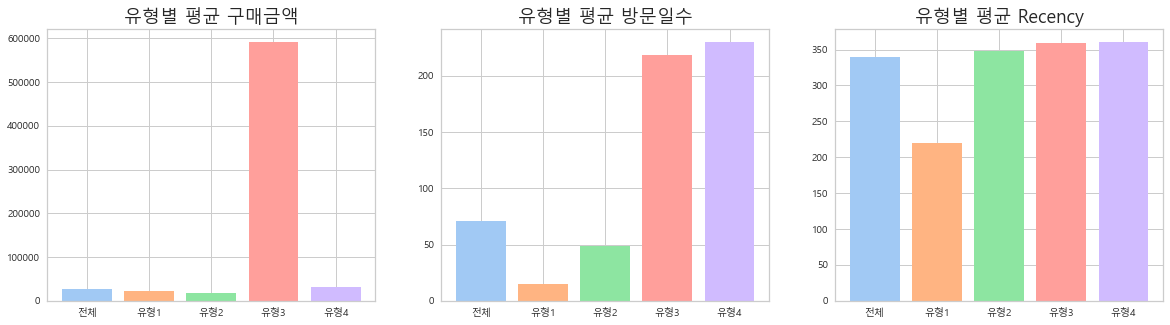

In [34]:
colors = sns.color_palette('pastel',5) # 색상 지정

plt.figure(figsize=(20,5))
# 구매금액
plt.subplot(1, 3, 1)
plt.bar(['전체', '유형1', '유형2', '유형3', '유형4'], [df['구매금액'].mean(), df.loc[df['고객번호'].isin(customer_0)]['구매금액'].mean(), df.loc[df['고객번호'].isin(customer_1)]['구매금액'].mean(),df.loc[df['고객번호'].isin(customer_2)]['구매금액'].mean(), 
                                             df.loc[df['고객번호'].isin(customer_3)]['구매금액'].mean()],color = colors)
plt.title('유형별 평균 구매금액', fontsize=18)
# 방문일수
plt.subplot(1, 3, 2)
plt.bar(['전체', '유형1', '유형2', '유형3', '유형4'],[df_rfm['Frequency'].mean(),df_rfm.loc[df_rfm['Customer_ID'].isin(customer_0)]['Frequency'].mean(),df_rfm.loc[df_rfm['Customer_ID'].isin(customer_1)]['Frequency'].mean(),
        df_rfm.loc[df_rfm['Customer_ID'].isin(customer_2)]['Frequency'].mean(), df_rfm.loc[df_rfm['Customer_ID'].isin(customer_3)]['Frequency'].mean()],color = colors)
plt.title('유형별 평균 방문일수', fontsize=18)

# Recency
plt.subplot(1, 3, 3)
plt.bar(['전체', '유형1', '유형2', '유형3', '유형4'], [df_rfm['Recency'].mean(),df_rfm.loc[df_rfm['Customer_ID'].isin(customer_0)]['Recency'].mean(),
        df_rfm.loc[df_rfm['Customer_ID'].isin(customer_1)]['Recency'].mean(),df_rfm.loc[df_rfm['Customer_ID'].isin(customer_2)]['Recency'].mean(), 
                                             df_rfm.loc[df_rfm['Customer_ID'].isin(customer_3)]['Recency'].mean()],color = colors)
plt.title('유형별 평균 Recency', fontsize=18)
plt.show()

*-유형1, 그냥 한번 들러봄*
- 유형1은 전체 데이터와 비교하였을 때, 평균 구매금액, 평균 방문일수, 평균 Recency모두가 낮은 것을 확인할 수 있다
    - 즉, 4개의 유형 중 가장 충성도가 낮은 고객이라고 할 수 있다.
    - 이후 마케팅 전략에서 해당 유형의 충성도를 높일 수 있는 전략을 짜면 좋을듯함

*-유형2, 다수*
- 유형2는 네개의 유형 중, 가장 속한 고객의 수가 높은 유형이다. 해당 그래프에서는 두드러지는 특징을 확인할 수 없다.

*-유형3, 충성고객VIP*
- 유형3은 네개의 유형 중, 속한 고객의 수가 가장 적은 유형이다. 해당 유형은 평균 구매금액이 다른 유형들에 비해 눈에 띄게 높음을 알 수 있다. 
- 또한, 평균 방문일수와 평균 Recency 또한 높음을 알 수 있다.
    - 쉽게 말해 본 회사의 VIP라고 볼 수 있다.
    - 이후 마케팅 전략에서 해당 유형은 이탈을 방지할 수 있는 전략을 수립하면 좋을듯함

*-유형4, 관심 고객*
- 유형4는 전체와 비교하였을 때, 평균 구매금액은 낮으나 평균 방문일수와 Recency점수가 높음을 알 수 있다.
    - 즉, 구매력은 높지 않으나 본회사에 지속적인 관심을 가지고 있음을 알 수 있다.
    - 이후 마케팅 전략에서 구매 금액을 지속적으로 향상시킬 수 있는 방안을 모색하면 좋을듯함

#### 유형별 연령대 분포

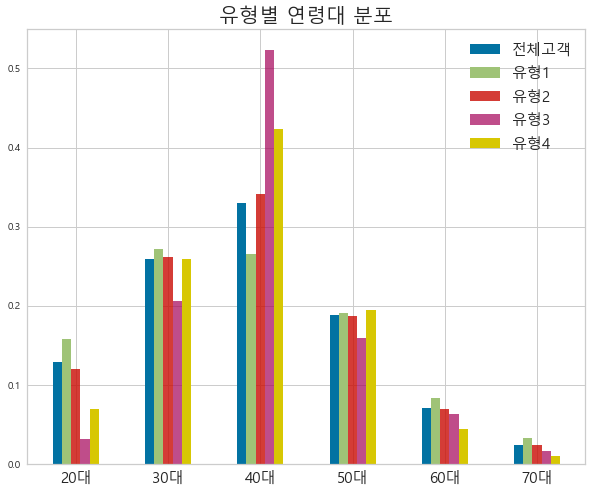

In [35]:
x = np.arange(6)

plt.figure(figsize=(10, 8))
# 전체
plt.bar(x-0.2, demo.groupby('연령대')['고객번호'].count().reset_index()['고객번호'] / demo.groupby('연령대')['고객번호'].count().sum(), 0.1, label='전체고객')
# 유형1
plt.bar(x-0.1,demo[demo['고객번호'].isin(customer_0)].groupby('연령대')['고객번호'].count().reset_index()['고객번호'] / \
               demo[demo['고객번호'].isin(customer_0)].groupby('연령대')['고객번호'].count().sum(), 0.1, label='유형1')
# 유형2
plt.bar(x,demo[demo['고객번호'].isin(customer_1)].groupby('연령대')['고객번호'].count().reset_index()['고객번호'] / \
               demo[demo['고객번호'].isin(customer_1)].groupby('연령대')['고객번호'].count().sum(), 0.1, label='유형2', alpha=0.8)
# 유형3
plt.bar(x+0.1,demo[demo['고객번호'].isin(customer_2)].groupby('연령대')['고객번호'].count().reset_index()['고객번호'] / \
               demo[demo['고객번호'].isin(customer_2)].groupby('연령대')['고객번호'].count().sum(), 0.1, label='유형3', alpha=0.7)

# 유형4
plt.bar(x+0.2,demo[demo['고객번호'].isin(customer_3)].groupby('연령대')['고객번호'].count().reset_index()['고객번호'] / \
               demo[demo['고객번호'].isin(customer_3)].groupby('연령대')['고객번호'].count().sum(), 0.1, label='유형4')

plt.xticks(x, ['20대', '30대', '40대', '50대', '60대', '70대'], fontsize = 15)
plt.legend(fontsize = 15)
plt.title('유형별 연령대 분포', fontsize=20)
plt.show()

- 각 유형별 평균 나이대를 확인해봄

In [36]:
# 유형1
demo[demo['고객번호'].isin(customer_0)]['연령대'].apply(lambda x:int(x[:2])).mean()

38.680248007085915

In [37]:
# 유형2
demo[demo['고객번호'].isin(customer_1)]['연령대'].apply(lambda x:int(x[:2])).mean()

38.93996755002704

In [38]:
# 유형3
demo[demo['고객번호'].isin(customer_2)]['연령대'].apply(lambda x:int(x[:2])).mean()

40.63492063492063

In [39]:
# 유형3
demo[demo['고객번호'].isin(customer_3)]['연령대'].apply(lambda x:int(x[:2])).mean()

39.15822072072072

*-유형1* 
- 유형1의 경우 30,50,60,70의 경우는 전체 고객과 비슷한 경향을 보임.
- 하지만 전체고객 대비 20대의 비율이 조금 높은 경향을 보이고, 40대의 비율은 적은 모습을 보인다.
    - 주 연령층이라고 볼 수 있는 20-50대 중, 구매력이 가장 낮은 20대의 비율이 높고, 구매력이 강한 40대의 비율은 낮은 모습을 보임

*-유형2*
- 유형2의 경우 전체 고객과 비교하였을 때, 두드러지는 특징을 찾기는 힘들어보임 

*-유형3*
- 유형3의 경우 전체 고객과 비교하여 보았을 때, 40대의 비율이 매우 높고, 20대의 비율은 매우 낮음을 볼 수 있다.
    - 구매력이 가장 크다고 볼 수 있는 연령층인 40대의 비율이 가장 높고, 구매력이 비교적 낮은 20대의 비율이 적음을 알 수 있다.

*-유형4*
- 유형4의 경우 또한 유형3과 비슷한 모습을 보인다.
    - 주 구성원은 비슷하나, 구매력에서 차이를 보이는 듯함
    - 이후 분석에서 구매력이 낮은 요인을 분석하고, 구매력은 있으나 구매를 하지 않는 경우 마케팅을 통해 구매를 유도하여 유형3과 같이 VIP로 전환 가능할듯함

#### 유형별 거주지 비교

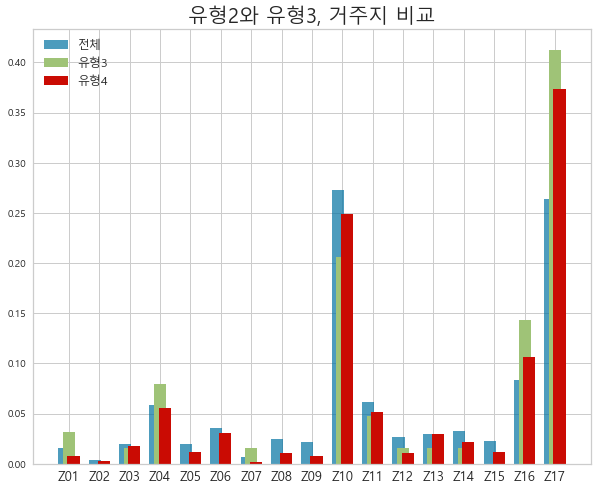

In [40]:
cust_2_resi = pd.concat([demo[demo['고객번호'].isin(customer_2)].groupby('거주지대분류코드')['고객번호'].count().reset_index(), 
           pd.DataFrame([['Z02', 0], ['Z05', 0], ['Z06', 0], ['Z08', 0], ['Z09', 0], ['Z15', 0]], 
           columns=['거주지대분류코드', '고객번호'])]).sort_values(by='거주지대분류코드').reset_index(drop=True)


plt.figure(figsize=(10, 8))
x = np.arange(len(cust_2_resi['거주지대분류코드']))
plt.bar(x-0.15, demo.groupby('거주지대분류코드')['고객번호'].count() /\
                demo.groupby('거주지대분류코드')['고객번호'].count().sum(), 0.4, label='전체', alpha=0.7)
plt.bar(x, cust_2_resi['고객번호'] / cust_2_resi['고객번호'].sum(), 0.4, label='유형3')
plt.bar(x+0.15, demo[demo['고객번호'].isin(customer_3)].groupby('거주지대분류코드')['고객번호'].count() /\
                demo[demo['고객번호'].isin(customer_3)].groupby('거주지대분류코드')['고객번호'].count().sum(), 0.4, label='유형4')

plt.xticks(x, cust_2_resi['거주지대분류코드'],fontsize = 13)
plt.legend(fontsize = 12)
plt.title('유형2와 유형3, 거주지 비교', fontsize = 20)
plt.show()

*전체적으로*
- 유형1, 2, 4는 전체 고객과 사는 지역의 분포가 비슷함 
    - 전부 확인하였지만 그래프의 가독성을 위하여 위의 세 그룹만 시각화함
- 유형3의 경우, 전체의 약 55-60%의 고객이 Z16, Z17지역에 거주 중임
    - 해당 지역을 찾을 수 있다면, 해당 지역에 해당 유형 고객이 많은 이유를 도출해낼 수 있을듯함
    - 확실한 결과는 아니지만 다른 깃헙 갱다녀온 결과 Z10:경기도, Z16:부산, Z17:서울임을 확인
-> 유형3의 데이터 수가 적어서 나타나는 현상일 수도 있음 *주의필요*

#### 유형별 주구매시간 파악

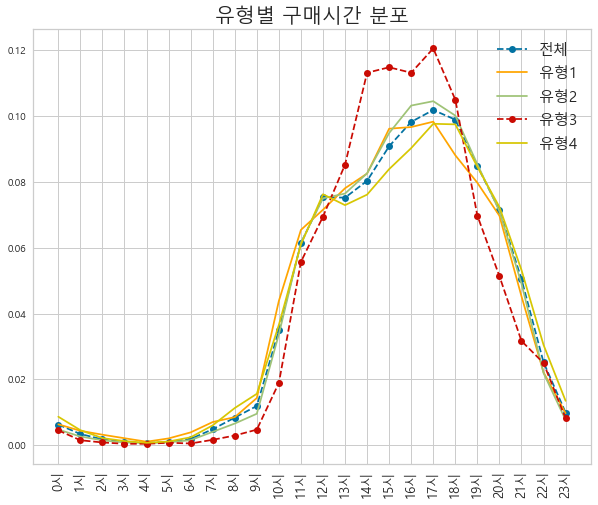

In [41]:
plt.figure(figsize=(10, 8))
x = np.arange(len(df['구매시간'].unique()))
plt.plot(df.groupby('구매시간')['고객번호'].count().reset_index()['구매시간'], 
         df.groupby('구매시간')['고객번호'].count().reset_index()['고객번호'] /\
         df.groupby('구매시간')['고객번호'].count().reset_index()['고객번호'].sum(), label='전체',linestyle='--',marker='o', c='b')
plt.plot(df[df['고객번호'].isin(customer_0)].groupby('구매시간')['고객번호'].count().reset_index()['구매시간'], 
         df[df['고객번호'].isin(customer_0)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'] /\
         df[df['고객번호'].isin(customer_0)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'].sum(), label='유형1', c='orange')
plt.plot(df[df['고객번호'].isin(customer_1)].groupby('구매시간')['고객번호'].count().reset_index()['구매시간'], 
         df[df['고객번호'].isin(customer_1)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'] /\
         df[df['고객번호'].isin(customer_1)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'].sum(), label='유형2',c='g')
plt.plot(df[df['고객번호'].isin(customer_2)].groupby('구매시간')['고객번호'].count().reset_index()['구매시간'], 
         df[df['고객번호'].isin(customer_2)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'] /\
         df[df['고객번호'].isin(customer_2)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'].sum(), label='유형3',linestyle='--',marker='o', c='r')
plt.plot(df[df['고객번호'].isin(customer_3)].groupby('구매시간')['고객번호'].count().reset_index()['구매시간'], 
         df[df['고객번호'].isin(customer_3)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'] /\
         df[df['고객번호'].isin(customer_3)].groupby('구매시간')['고객번호'].count().reset_index()['고객번호'].sum(), label='유형4', c='y')
plt.xticks(x, [f'{i}시' for i in range(24)],fontsize = 13)
plt.xticks(rotation=90) #x축 값 세로로 변경
plt.title('유형별 구매시간 분포', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

- 전체와 비교하였을 때, 다른 유형들은 별다른 특이점이 없는 반면 유형3의 경우 오후 2시에 구매율이 높은 것을 확인할 수 있다.

### 유형별 시각화 (각 유형별로 df 확인)

- 채널

In [42]:
# 전체
df.groupby('채널구분')['고객번호'].count() / df.groupby('채널구분')['고객번호'].count().sum()

채널구분
1    0.87068
2    0.12932
Name: 고객번호, dtype: float64

In [43]:
# 유형1
df[df['고객번호'].isin(customer_0)].groupby('채널구분')['고객번호'].count() / df[df['고객번호'].isin(customer_0)].groupby('채널구분')['고객번호'].count().sum()

채널구분
1    0.879881
2    0.120119
Name: 고객번호, dtype: float64

In [44]:
# 유형2
df[df['고객번호'].isin(customer_1)].groupby('채널구분')['고객번호'].count() / df[df['고객번호'].isin(customer_1)].groupby('채널구분')['고객번호'].count().sum()

채널구분
1    0.903877
2    0.096123
Name: 고객번호, dtype: float64

In [45]:
# 유형3
df[df['고객번호'].isin(customer_2)].groupby('채널구분')['고객번호'].count() / df[df['고객번호'].isin(customer_2)].groupby('채널구분')['고객번호'].count().sum()

채널구분
1    0.916264
2    0.083736
Name: 고객번호, dtype: float64

In [46]:
# 유형4
df[df['고객번호'].isin(customer_3)].groupby('채널구분')['고객번호'].count() / df[df['고객번호'].isin(customer_3)].groupby('채널구분')['고객번호'].count().sum()

채널구분
1    0.817577
2    0.182423
Name: 고객번호, dtype: float64

    - 유형별로 채널에 따른 특징은 없다고 봐도 무방함 -> 이후에 구체적으로 시각화 예정

#### Lpay

- Lpay와 상품을 동시에 결제한 경우

In [47]:
unuse_Lpay = demo[demo['고객번호'].isin(set(df[df['타입'] == 'Lpay']['고객번호'])) == False]['고객번호']
useLpay = demo[demo['고객번호'].isin(set(df[df['타입'] == 'Lpay']['고객번호']))]['고객번호']

In [48]:
# Lpay와 상품 구매를 동시에 한 영수증은 없음 ( ex) 결제 금액이 40500일 경우 500만 포인트로 결제하는 등의 경우는 없음 )
len(df[df['타입'] != 'Lpay'][df[df['타입'] != 'Lpay']['영수증번호'].isin(set(df[df['타입'] == 'Lpay']['영수증번호']))])

0

- Lpay이용자의 비율을 확인

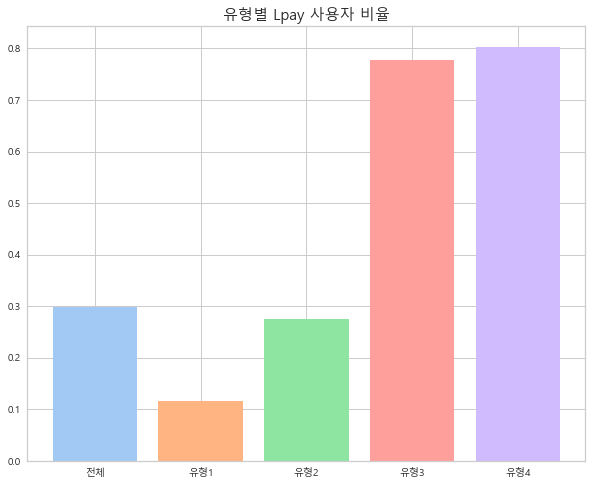

In [49]:
# Lpay이용자의 비율을 확인해봄
## 전체
lpay_ratio = [(len(useLpay) / len(demo)),  (len(customer_0[customer_0.isin(useLpay)]) / len(customer_0)), (len(customer_1[customer_1.isin(useLpay)]) / len(customer_1)),
            (len(customer_2[customer_2.isin(useLpay)]) / len(customer_2)), (len(customer_3[customer_3.isin(useLpay)]) / len(customer_3))]

colors = sns.color_palette('pastel',5)
plt.figure(figsize=(10, 8))
plt.bar(['전체', '유형1', '유형2', '유형3', '유형4'], lpay_ratio, color = colors)
plt.title('유형별 Lpay 사용자 비율', fontsize=15)
plt.show()

    - 전체와 비교해 보았을 때, 유형1의 경우 Lpay이용자의 수가 매우 적고, 유형3,4의 경우 이용률이 높음을 알 수 있음. 
    - 특히,유형3의 이용률은 많이 높음 -> 위의 시각화 결과와 맥이 통하는 모습을 보임

- Lpay 이용자와 미이용자의 평균 구매금액 비교

In [50]:
lpay_x = [
          df[df['고객번호'].isin(unuse_Lpay)]['구매금액'].mean(),
          df[df['고객번호'].isin(customer_0[customer_0.isin(useLpay)==False])]['구매금액'].mean(),
          df[df['고객번호'].isin(customer_1[customer_1.isin(useLpay)==False])]['구매금액'].mean(), 
          df[df['고객번호'].isin(customer_2[customer_2.isin(useLpay)==False])]['구매금액'].mean(),
          df[df['고객번호'].isin(customer_3[customer_3.isin(useLpay)==False])]['구매금액'].mean()
         ]
lpay_o = [df[df['고객번호'].isin(useLpay)]['구매금액'].mean(), df[df['고객번호'].isin(customer_0[customer_0.isin(useLpay)])]['구매금액'].mean(),
          df[df['고객번호'].isin(customer_1[customer_1.isin(useLpay)])]['구매금액'].mean(), df[df['고객번호'].isin(customer_2[customer_2.isin(useLpay)])]['구매금액'].mean(),
          df[df['고객번호'].isin(customer_3[customer_3.isin(useLpay)])]['구매금액'].mean()]

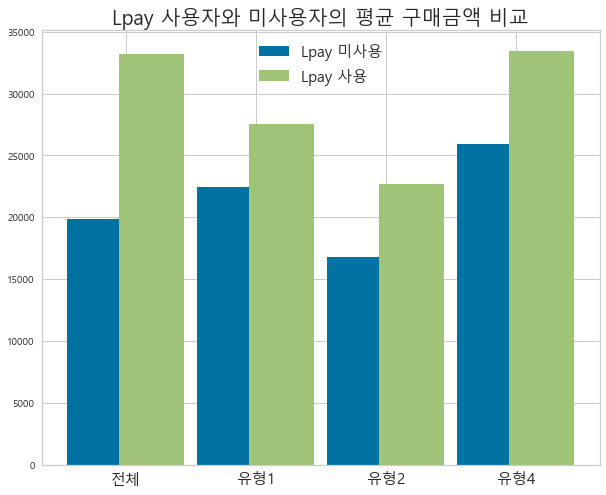

In [51]:
# 유형 3의 경우 Lpay를 사용하지 않는 고객의 평균 구매비용이 더 높음
x = np.arange(4)

plt.figure(figsize=(10, 8))
plt.bar(x-0.2, [lpay_x[0], lpay_x[1], lpay_x[2], lpay_x[4]], 0.5, label='Lpay 미사용')
plt.bar(x+0.2, [lpay_o[0], lpay_o[1], lpay_o[2], lpay_o[4]], 0.5, label='Lpay 사용')
plt.xticks(x, ['전체', '유형1', '유형2', '유형4'], fontsize = 15)
plt.legend(fontsize = 15)
plt.title('Lpay 사용자와 미사용자의 평균 구매금액 비교', fontsize=20)
plt.show()

    - 유형3을 제외한 나머지 유형들은 Lpay를 사용하는 고객의 평균 구매금액이 더 높음을 알 수 있다.

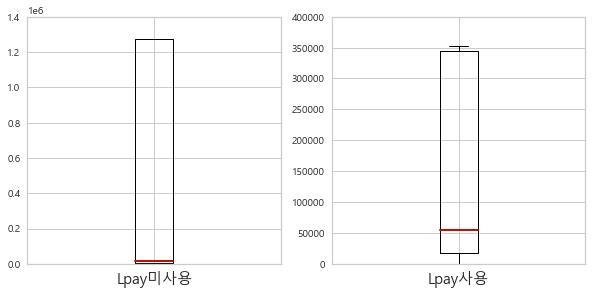

In [52]:
plt.figure(figsize=(10,10))
# 엘페이 미사용
plt.subplot(2, 2, 1)
plt.boxplot(df[df['타입'] != 'Lpay']['구매금액'].describe(), medianprops=dict(color='r', linewidth=2))
plt.xticks([1],['Lpay미사용'], fontsize=15)
plt.ylim([0, 1400000])
# 엘페이 사용
plt.subplot(2, 2, 2)
plt.boxplot(df[df['타입'] == 'Lpay']['구매금액'].describe(), medianprops=dict(color='r', linewidth=2))
plt.xticks([1],['Lpay사용'], fontsize=15)
plt.ylim([0, 400000])
plt.show()

    - 하지만 이는 단순히 Lpay로 결제하였을 때의 금액이 평소 구매금액보다 큰 경우인듯함
    - 위의 사분위수를 보면 단순 구매액보다 Lpay구매액이 더 높음
    
    -> 정리해보면, 유형1,2,4의 경우 Lpay로 결제하는 금액이 평소 결제하는 금액보다 높음을 알 수 있음
        - 이후 분석 진행시 Lpay를 더 많이 사용하게 할 방법을 모색한다면 구매금액 측면에서 회사에 도움이 되는 결과를 얻을 수 있으리라 생각함

### 가장 많이 구매한 품목 확인

- 대, 중, 소분류 모두 확인해 보았으나 유형별 특징을 가장 잘 나타내는 중분류명으로 진행

In [53]:
most_buy = df.groupby('고객번호')['중분류명'].apply(list).apply(lambda x:max(x, key = x.count)).reset_index()

In [54]:
# # 전체
# most_buy.groupby('중분류명').count().sort_values(by='고객번호', ascending = False)[0:4]

In [55]:
# # 유형1
# most_buy[most_buy['고객번호'].isin(customer_0)].groupby('중분류명').count().sort_values(by='고객번호', ascending = False)[0:4]

In [56]:
# # 유형2
# most_buy[most_buy['고객번호'].isin(customer_1)].groupby('중분류명').count().sort_values(by='고객번호', ascending = False)[0:4]

In [57]:
# # 유형3
# most_buy[most_buy['고객번호'].isin(customer_2)].groupby('중분류명').count().sort_values(by='고객번호', ascending = False)[0:4]

In [58]:
# # 유형4
# most_buy[most_buy['고객번호'].isin(customer_3)].groupby('중분류명').count().sort_values(by='고객번호', ascending = False)[0:4]

- wordcloud로 확인

In [59]:
from wordcloud import WordCloud
from collections import Counter

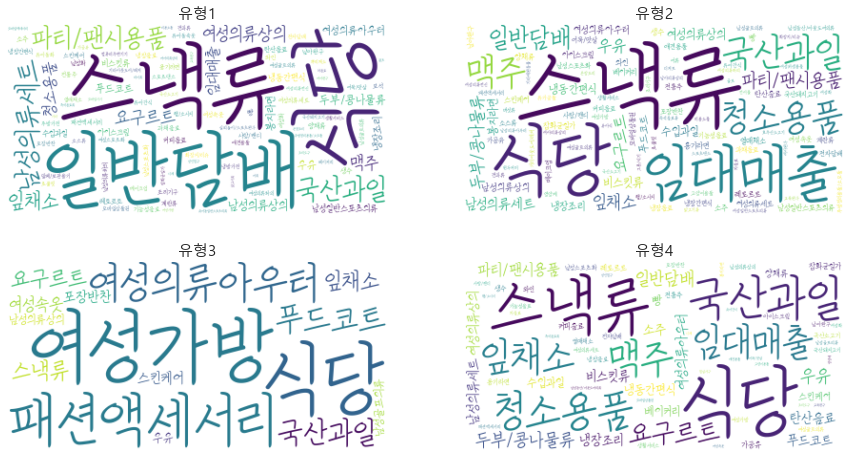

In [60]:
fontpath = '../data/DXBarunscriptM-KSCpc-EUC-H.ttf'

wordcloud_0 = WordCloud(
                      font_path = fontpath, 
                      background_color='white',
                      random_state = 20, 
                      max_words = 200).generate_from_frequencies(Counter(most_buy[most_buy['고객번호'].isin(customer_0)]['중분류명'].dropna()))
wordcloud_1 = WordCloud(
                      font_path = fontpath, 
                      background_color='white',
                      random_state = 20, 
                      max_words = 200).generate_from_frequencies(Counter(most_buy[most_buy['고객번호'].isin(customer_1)]['중분류명'].dropna()))
wordcloud_2 = WordCloud(
                      font_path = fontpath, 
                      background_color='white',
                      random_state = 20, 
                      max_words = 200).generate_from_frequencies(Counter(most_buy[most_buy['고객번호'].isin(customer_2)]['중분류명'].dropna()))
wordcloud_3 = WordCloud(
                      font_path = fontpath, 
                      background_color='white',
                      random_state = 20, 
                      max_words = 200).generate_from_frequencies(Counter(most_buy[most_buy['고객번호'].isin(customer_3)]['중분류명'].dropna()))



plt.figure(figsize = (15, 8))
# 유형1
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_0, interpolation = "bilinear")
plt.axis("off")
plt.title('유형1', fontsize=15)
# 유형2
plt.subplot(2, 2, 2)
plt.imshow(wordcloud_1, interpolation = "bilinear")
plt.axis("off")
plt.title('유형2', fontsize=15)
# 유형3
plt.subplot(2, 2, 3)
plt.imshow(wordcloud_2, interpolation = "bilinear")
plt.axis("off")
plt.title('유형3', fontsize=15)
# 유형4
plt.subplot(2, 2, 4)
plt.imshow(wordcloud_3, interpolation = "bilinear")
plt.axis("off")
plt.title('유형4', fontsize=15)
plt.show()

*- 유형1,* 
- 지난 RFM시각화에서  '주방가전' 

*- 유형2,*
- 보편적으로 많이 나타나는 품목들을 제외하고, 해당 유형의 고객들은 '임대매출'이 많이 나타남.
- 아래에서 '임대매출'에 대한 분석을 진행함.
    - '그린카'와 같은 자동차 임대업일 확률이 높음
    - 해당 품목을 많이 사는 고객들로 이루어져있기 때문에 이에 관한 마케팅을 진행하면 좋을듯함
    - 하지만, '임대매출'을 구매한 고객이 아닌 고객도 해당 유형에 포함돼 있기 때문에 이들에 대한 고려도 필요할듯함

*- 유형3,*
- 계속되는 시각화 결과에서 말해주듯, 해당 유형은 VIP.
    - 구매 품목 또한 '명품'으로 줄여서 생각해도 될 듯함

*- 유형4,*
- 한마디로 '주부'라고 볼 수 있는 품목들을 많이 구매함
    - 이전의 RFM시각화 결과를 바탕으로 확인한 결과 해당 유형의 고객들은 구매금액은 낮지만 충성도는 매우 높은 유형의 고객으로 분류 가능

    - 임대매출?

In [61]:
# 유통사는 A01혹은 A02
df[df['중분류명'] =='임대매출'].groupby('제휴사').count()['고객번호']

제휴사
A01    33417
A02       77
Name: 고객번호, dtype: int64

In [62]:
# 상품 코드는 PD0288로 한개
df[df['중분류명'] =='임대매출'].groupby('상품코드').count()['고객번호']

상품코드
PD0288    33494
Name: 고객번호, dtype: int64

In [63]:
# 구매금액은 보통 3만원~4만원 정도
df[df['중분류명'] =='임대매출']['구매금액'].describe()

count    3.349400e+04
mean     3.675424e+04
std      8.263915e+04
min      1.000000e+01
25%      1.000000e+04
50%      2.279000e+04
75%      4.070000e+04
max      1.000000e+07
Name: 구매금액, dtype: float64

In [64]:
# # 구매일자에 똑같은 날짜가 있다..? -> 렌탈을 여러개해서 한번에 결제된걸수도?
# df[df['중분류명'] =='임대매출'].groupby('고객번호')['구매일자'].apply(list)

In [65]:
# 10번 이상 이용한 고객은 적음 -> 일회성이 짙은 렌탈 품목일 가능성 높음
df[df['중분류명'] =='임대매출'].groupby('고객번호').count().sort_values('영수증번호', ascending = False)['영수증번호'].describe()

count    3658.000000
mean        9.156370
std        13.843579
min         1.000000
25%         2.000000
50%         4.000000
75%        11.000000
max       146.000000
Name: 영수증번호, dtype: float64

In [66]:
# 예시로 살펴본 결과 구매 금액과 일자가 일정하지 않은 것을 알 수 있음
df[(df['중분류명'] =='임대매출') & (df['고객번호'] == 'M438405999')][['고객번호', '성별', '연령대', '구매일자', '구매시간', '날짜', '구매금액', '거주지대분류코드', '점포대분류코드']]

,고객번호,성별,연령대,구매일자,구매시간,날짜,구매금액,거주지대분류코드,점포대분류코드
49749,M438405999,여성,30대,20210204,11,2021-02-04,6600,Z10,Z10
52543,M438405999,여성,30대,20210205,18,2021-02-05,210000,Z10,Z10
52595,M438405999,여성,30대,20210205,18,2021-02-05,4000,Z10,Z10
54023,M438405999,여성,30대,20210206,15,2021-02-06,22000,Z10,Z10
59915,M438405999,여성,30대,20210209,14,2021-02-09,6000,Z10,Z10
...,...,...,...,...,...,...,...,...,...
653770,M438405999,여성,30대,20211224,12,2021-12-24,12000,Z10,Z10
653752,M438405999,여성,30대,20211224,12,2021-12-24,31000,Z10,Z10
662183,M438405999,여성,30대,20211227,14,2021-12-27,36000,Z10,Z10
667848,M438405999,여성,30대,20211231,11,2021-12-31,10600,Z10,Z10


    - 확실하지는 않지만 그린카, 롯데 렌터카, 숙박 등의 임대업이 아닐까 예상
    - but, 숙박비가 숙박이라고 쳤을때, 가격 분포가 너무 쌈
    - 그렇다면 높은 확률로 자동차, 롯데 렌탈 등 임대업일 확률이 높지 않을까 생각
    - 이후 한달주기로 동일한 금액이 결제된다면 롯데 렌탈일 확률이 높음 
        -> 구매금액과 주기가 일정하지 않은 것으로 보아 아닌듯함
https://www.lotterental.com/homepage/html/web/business/LPB03001.html -> 이 품목들일수도 있음 ( 롯데렌탈 )

### 유형1과 유형2의 특징을 잡아보자

- 온라인, 오프라인 이용 여부를 파이차트를 통해 확인

In [67]:
ch = df.groupby('고객번호')['채널구분'].apply(list).reset_index()

In [68]:
# 온라인 오프라인 이용 여부를 세가지로 나누어 확인
def div_ch(x):
    if set(x) == {1}: # 오프라인만 이용하는 경우
        return '오프라인'
    elif set(x) == {2}: # 온라인만 이용
        return '온라인'
    else: # 둘다이용
        return '둘다이용'

# 이용채널과 이용 횟수를 구해줌
ch['이용채널'] = ch['채널구분'].apply(div_ch)
ch['이용횟수'] = ch['채널구분'].apply(lambda x:len(x))

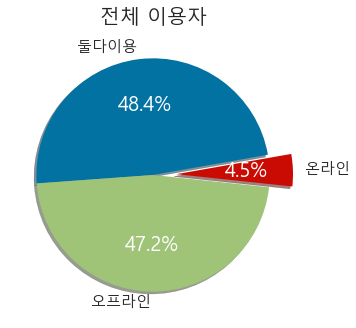

In [69]:
plt.figure(figsize=(5,5))
patches, texts, autotexts = plt.pie(
    ch.groupby('이용채널').count().reset_index()['고객번호'],
    labels = ch.groupby('이용채널').count().reset_index()['이용채널'],
    labeldistance=1.1,## label이 파이로부터 얼마나 떨어지는가, 1일경우 딱 붙어있음. 
    explode=[0, 0, 0.2], ##pie가 튀어나오는지 정해줌  
    startangle=10,## 어디에서 시작할지, 정해줌  
    shadow=True, ##그림자 
    autopct='%1.1f%%') ## pi 위에 표시될 글자 형태, 또한 알아서 %로 변환해서 알려줌 
plt.title('전체 이용자', size = 20)
for t in autotexts:
    t.set_color("white")
    t.set_fontsize(20)
    
for t in texts:
    t.set_fontsize(15)

plt.tight_layout()
plt.show()

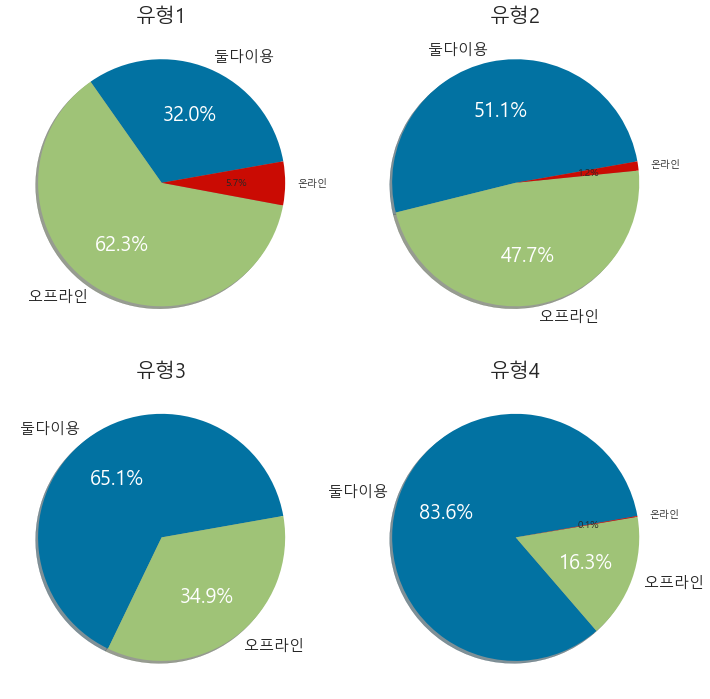

In [70]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
patches_0, texts_0, autotexts_0 = plt.pie(
    ch[ch['고객번호'].isin(customer_0)].groupby('이용채널').count().reset_index()['고객번호'],
    labels = ch[ch['고객번호'].isin(customer_0)].groupby('이용채널').count().reset_index()['이용채널'],
    labeldistance=1.1,## label이 파이로부터 얼마나 떨어지는가, 1일경우 딱 붙어있음. 
#     explode=[0, 0.1, 0], ##pie가 튀어나오는지 정해줌  
    startangle=10,## 어디에서 시작할지, 정해줌  
    shadow=True, ##그림자 
    autopct='%1.1f%%', ## pi 위에 표시될 글자 형태, 또한 알아서 %로 변환해서 알려줌 
)
plt.title('유형1', size = 20)

plt.subplot(2, 2, 2)
patches_1, texts_1, autotexts_1 = plt.pie(
    ch[ch['고객번호'].isin(customer_1)].groupby('이용채널').count().reset_index()['고객번호'],
    labels = ch[ch['고객번호'].isin(customer_1)].groupby('이용채널').count().reset_index()['이용채널'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형2', size = 20)

plt.subplot(2, 2, 3)
patches_2, texts_2, autotexts_2 = plt.pie(
    ch[ch['고객번호'].isin(customer_2)].groupby('이용채널').count().reset_index()['고객번호'],
    labels = ch[ch['고객번호'].isin(customer_2)].groupby('이용채널').count().reset_index()['이용채널'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형3', size = 20)

plt.subplot(2, 2, 4)
patches_3, texts_3, autotexts_3 = plt.pie(
    ch[ch['고객번호'].isin(customer_3)].groupby('이용채널').count().reset_index()['고객번호'],
    labels = ch[ch['고객번호'].isin(customer_3)].groupby('이용채널').count().reset_index()['이용채널'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형4', size = 20)

for t1, t2, t3, t4 in zip(autotexts_0, autotexts_1, autotexts_2, autotexts_3):
    t1.set_color("white")
    t1.set_fontsize(20)
    t2.set_color("white")
    t2.set_fontsize(20)
    t3.set_color("white")
    t3.set_fontsize(20)
    t4.set_color("white")
    t4.set_fontsize(20)

for t1,t2,t3,t4 in zip(texts_0, texts_1, texts_2, texts_3):
    t1.set_fontsize(15)
    t2.set_fontsize(15)
    t3.set_fontsize(15)
    t4.set_fontsize(15)
    
plt.tight_layout()
plt.show()

*유형1*
- 온라인만 이용하는 고객의 비율이 가장 높은 모습을 보임
    - 이전의 분석에서 전체 대비 20대의 비율이 높게 나타난 것과 연관지어 온라인에 접근성이 높은 모습을 보임
- 반면, 타 집단 대비 오프라인만 사용하는 이용자 또한 높게 나타나는 것을 확인할 수 있음
    - 마케팅을 진행할 때, 한쪽 집단에만 치우친 마케팅을 해서는 안될듯함

#### 이용 채널과 이용 횟수를 확인
    - 시각적 효과를 높이기 위해 y축의 범위를 조절함
    - 대부분의 데이터가 어디에 분포돼있는지만 확인하면 될듯함

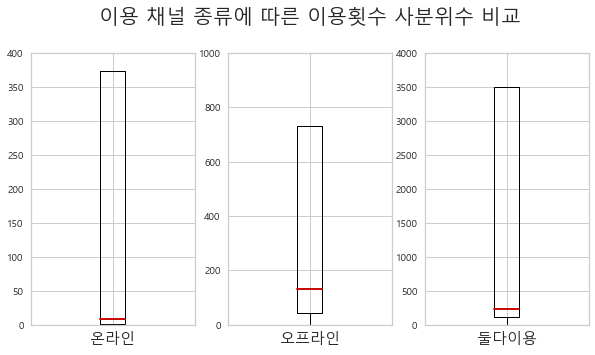

In [71]:
plt.figure(figsize=(10,5))
# 온라인
plt.subplot(1, 3, 1)
plt.boxplot(ch[ch['이용채널'] == '온라인']['이용횟수'].describe(), medianprops=dict(color='r', linewidth=2))
plt.xticks([1],['온라인'], fontsize=15)
plt.ylim([0, 400])
# 오프라인
plt.subplot(1, 3, 2)
plt.boxplot(ch[ch['이용채널'] == '오프라인']['이용횟수'].describe(), medianprops=dict(color='r', linewidth=2))
plt.title('이용 채널 종류에 따른 이용횟수 사분위수 비교\n', fontsize=20)
plt.xticks([1],['오프라인'], fontsize=15)
plt.ylim([0, 1000])
# 둘다
plt.subplot(1, 3, 3)
plt.boxplot(ch[ch['이용채널'] == '둘다이용']['이용횟수'].describe(), medianprops=dict(color='r', linewidth=2))
plt.xticks([1],['둘다이용'], fontsize=15)
plt.ylim([0, 4000])
plt.show()

- 유형1
     - 온라인만을 이용하는 고객은 방문 횟수가 매우 낮음 ( 3사분위까지 5번 안쪽 )
         - 때문에 온라인만 이용하는 고객의 비율이 높은 유형1의 경우 RFM시각화가 이전과 같은 결과를 보이는 것임
         - 해당 유형에는 온라인과 오프라인에 대한 복합적인 마케팅 전략이 필요할듯함
- 유형2,4
    - 위의 사분위수 그래프를 보면 오프라인만 이용하는 고객보다 온라인과 오프라인 모두 사용하는 고객의 경우 방문 횟수가 더 높음을 알 수 있다.
    - 따라서 이전 RFM그래프에서 유형2의 문제였던 방문횟수를 온라인 홍보를 통해 올릴 수 있을 것이라 판단됨
    - 파이차트를 보았을 때, 유형2의 형태를 유형4의 형태로 변할 수 있도록 마케팅을 진행한다면 보다 충성도가 높은 고객을 유치할 수 있을 것이라고 판단됨

#### 구매 품목 살펴보기

In [72]:
df[(df['고객번호'].isin(customer_3)) & (df['채널구분'] == 2)].groupby('중분류명').count().sort_values('고객번호', ascending=False)[:10].index

Index(['우유', '국산과일', '스낵류', '잎채소', '두부/콩나물류', '냉동간편식', '요구르트', '봉지라면', '레토르트',
       '모바일상품권'],
      dtype='object', name='중분류명')

In [73]:
df[(df['고객번호'].isin(customer_2)) & (df['채널구분'] == 2)].groupby('중분류명').count().sort_values('고객번호', ascending=False)[:10].index

Index(['컴퓨터주변기기', '스킨케어', '냉동간편식', '국산과일', '우유', '계란류', '탄산음료', '스낵류', '용기라면',
       '레토르트'],
      dtype='object', name='중분류명')

- 성별

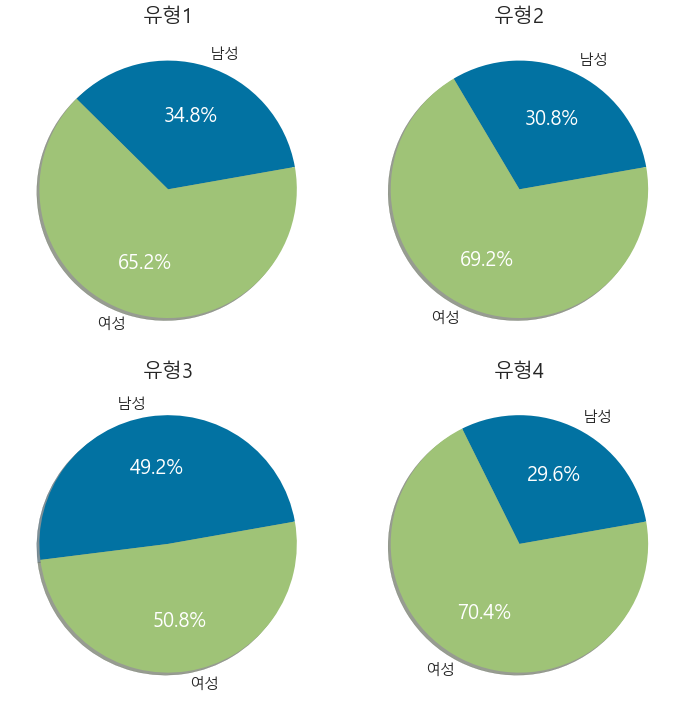

In [74]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
patches_0, texts_0, autotexts_0 = plt.pie(
    demo[demo['고객번호'].isin(customer_0)].groupby('성별').count()['고객번호'] / demo[demo['고객번호'].isin(customer_0)].groupby('성별').count()['고객번호'].sum(),
    labels = ['남성', '여성'],
    labeldistance=1.1,## label이 파이로부터 얼마나 떨어지는가, 1일경우 딱 붙어있음. 
#     explode=[0, 0.1, 0], ##pie가 튀어나오는지 정해줌  
    startangle=10,## 어디에서 시작할지, 정해줌  
    shadow=True, ##그림자 
    autopct='%1.1f%%', ## pi 위에 표시될 글자 형태, 또한 알아서 %로 변환해서 알려줌 
)
plt.title('유형1', size = 20)

plt.subplot(2, 2, 2)
patches_1, texts_1, autotexts_1 = plt.pie(
    demo[demo['고객번호'].isin(customer_1)].groupby('성별').count()['고객번호'] / demo[demo['고객번호'].isin(customer_1)].groupby('성별').count()['고객번호'].sum(),
    labels = ['남성', '여성'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형2', size = 20)

plt.subplot(2, 2, 3)
patches_2, texts_2, autotexts_2 = plt.pie(
    demo[demo['고객번호'].isin(customer_2)].groupby('성별').count()['고객번호'] / demo[demo['고객번호'].isin(customer_2)].groupby('성별').count()['고객번호'].sum(),
    labels = ['남성', '여성'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형3', size = 20)

plt.subplot(2, 2, 4)
patches_3, texts_3, autotexts_3 = plt.pie(
    demo[demo['고객번호'].isin(customer_3)].groupby('성별').count()['고객번호'] / demo[demo['고객번호'].isin(customer_3)].groupby('성별').count()['고객번호'].sum(),
    labels = ['남성', '여성'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형4', size = 20)

for t1, t2, t3, t4 in zip(autotexts_0, autotexts_1, autotexts_2, autotexts_3):
    t1.set_color("white")
    t1.set_fontsize(20)
    t2.set_color("white")
    t2.set_fontsize(20)
    t3.set_color("white")
    t3.set_fontsize(20)
    t4.set_color("white")
    t4.set_fontsize(20)

for t1,t2,t3,t4 in zip(texts_0, texts_1, texts_2, texts_3):
    t1.set_fontsize(15)
    t2.set_fontsize(15)
    t3.set_fontsize(15)
    t4.set_fontsize(15)
    
plt.tight_layout()
plt.show()

- 타 유형 대비 유형3은 남성의 비율이 높음을 알 수 있음

### 이탈 위험비율

- 유형별 이탈 위험률 분포

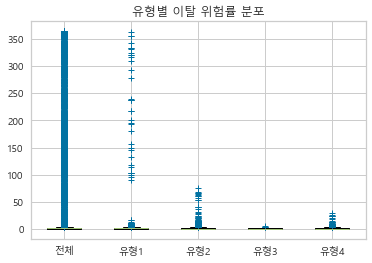

In [82]:
fig, ax = plt.subplots()
ax.boxplot([churn['이탈위험비율'],
            churn[churn['고객번호'].isin(customer_0)]['이탈위험비율'],
           churn[churn['고객번호'].isin(customer_1)]['이탈위험비율'],
           churn[churn['고객번호'].isin(customer_2)]['이탈위험비율'],
           churn[churn['고객번호'].isin(customer_3)]['이탈위험비율']], sym="b+")
plt.title('유형별 이탈 위험률 분포')
plt.xticks([1, 2, 3, 4, 5],['전체', '유형1', '유형2', '유형3', '유형4'])
plt.show()

### 날짜별 활동량 추이 확인

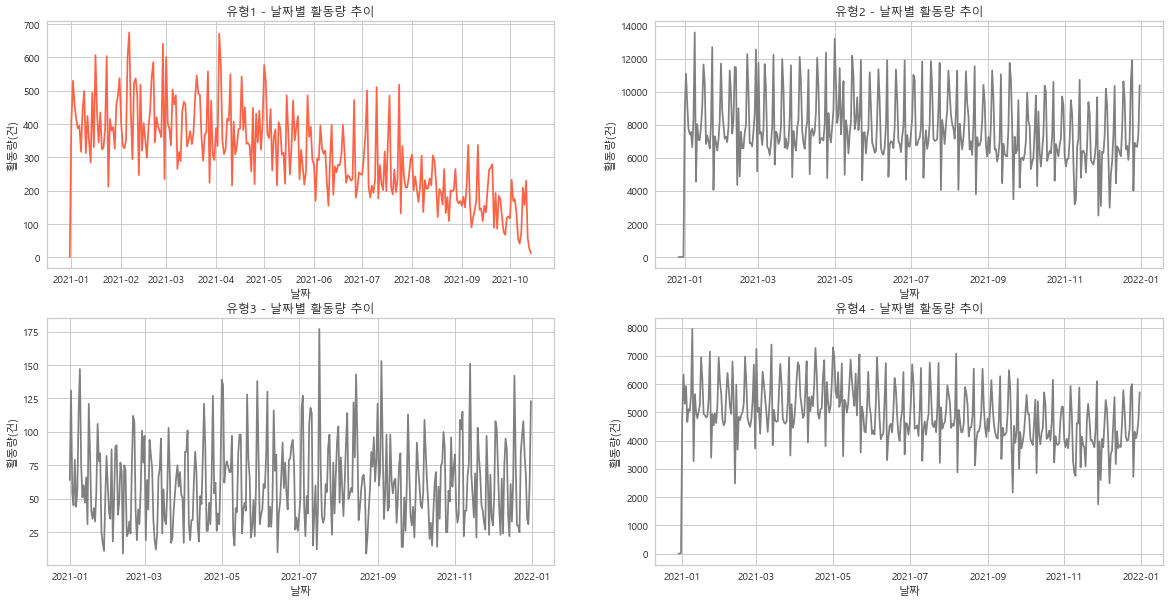

In [86]:
cust0_df = df[df['고객번호'].isin(customer_0)]
cust0_df = cust0_df.groupby('날짜').size().to_frame('count').reset_index()

cust1_df = df[df['고객번호'].isin(customer_1)]
cust1_df = cust1_df.groupby('날짜').size().to_frame('count').reset_index()

cust2_df = df[df['고객번호'].isin(customer_2)]
cust2_df = cust2_df.groupby('날짜').size().to_frame('count').reset_index()

cust3_df = df[df['고객번호'].isin(customer_3)]
cust3_df = cust3_df.groupby('날짜').size().to_frame('count').reset_index()


plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
sns.lineplot(data=cust0_df, x='날짜', y='count', color='tomato')
plt.title('유형1 - 날짜별 활동량 추이')
plt.xlabel('날짜'); plt.ylabel('활동량(건)')

plt.subplot(2, 2, 2)
sns.lineplot(data=cust1_df, x='날짜', y='count', color='gray')
plt.title('유형2 - 날짜별 활동량 추이')
plt.xlabel('날짜'); plt.ylabel('활동량(건)')

plt.subplot(2, 2, 3)
sns.lineplot(data=cust2_df, x='날짜', y='count', color='gray')
plt.title('유형3 - 날짜별 활동량 추이')
plt.xlabel('날짜'); plt.ylabel('활동량(건)')

plt.subplot(2, 2, 4)
sns.lineplot(data=cust3_df, x='날짜', y='count', color='gray')
plt.title('유형4 - 날짜별 활동량 추이')
plt.xlabel('날짜'); plt.ylabel('활동량(건)')

plt.show()

    - 이탈 위험 비율과 비슷하게 유형1의 경우 시간이 지날수록 활동량이 줄어드는 모습을 보임

In [87]:
demo['유형'] = demo['성별'] + ' ' + demo['연령대']

In [89]:
user = demo[demo['고객번호'].isin(trans['고객번호'])].reset_index(drop=True)
user['거래횟수'] = trans['거래횟수']

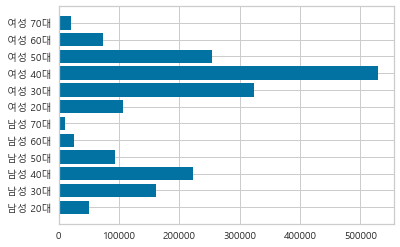

In [90]:
plt.barh(user.groupby('유형')['거래횟수'].sum().reset_index()['유형'], user.groupby('유형')['거래횟수'].sum().reset_index()['거래횟수'])

plt.show()

### 무지성 EDA

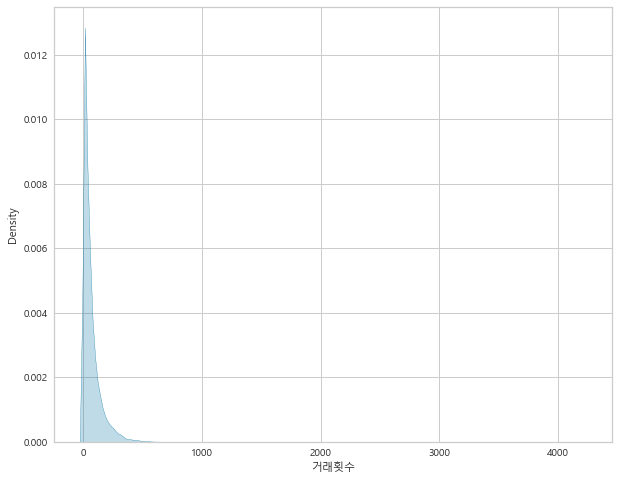

In [94]:
fig = plt.figure(figsize = (10,8))
sns.kdeplot(trans['거래횟수'],shade = True)
plt.show()

In [147]:
user = df.groupby('고객번호')['구매일자'].apply(set).reset_index()
user['첫구매일자'] = user['구매일자'].apply(lambda x:sorted(list(x))[0])

user['회원기간'] = pd.to_datetime('311221') - pd.to_datetime(user['첫구매일자'].astype(str))
user['회원기간'] = user['회원기간'].dt.days

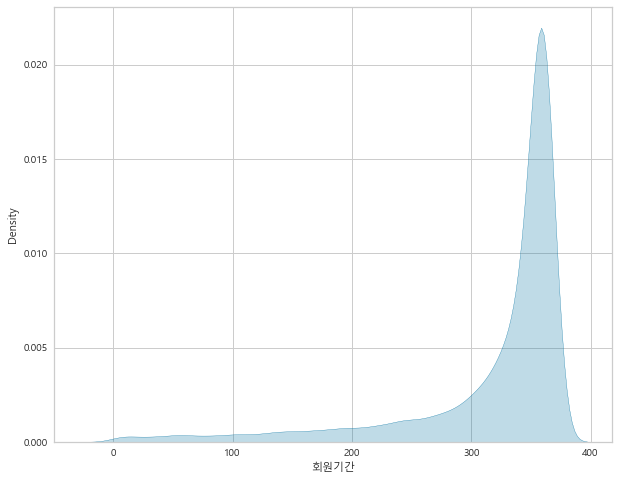

In [149]:
fig = plt.figure(figsize = (10,8))
sns.kdeplot(user['회원기간'],shade = True)
plt.show()

In [157]:
user['거래품목대분류수'] = df.groupby('고객번호')['대분류명'].apply(set).reset_index()['대분류명'].apply(lambda x:len(x))

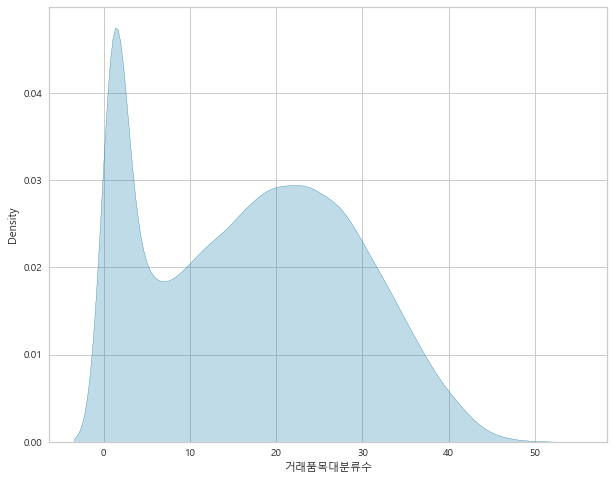

In [158]:
fig = plt.figure(figsize = (10,8))
sns.kdeplot(user['거래품목대분류수'],shade = True)
plt.show()

- 유형별 거래대분류 품목수

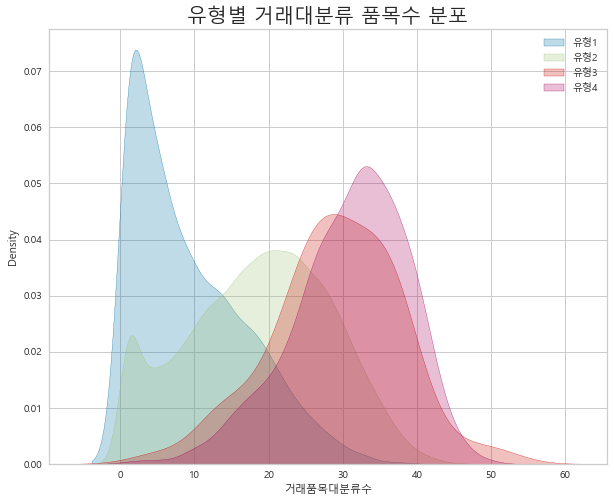

In [167]:
fig = plt.figure(figsize = (10,8))
sns.kdeplot(user[user['고객번호'].isin(customer_0)]['거래품목대분류수'], label = '유형1',shade = True)
sns.kdeplot(user[user['고객번호'].isin(customer_1)]['거래품목대분류수'], label = '유형2',shade = True)
sns.kdeplot(user[user['고객번호'].isin(customer_2)]['거래품목대분류수'], label = '유형3',shade = True)
sns.kdeplot(user[user['고객번호'].isin(customer_3)]['거래품목대분류수'], label = '유형4',shade = True)
plt.title('유형별 거래대분류 품목수 분포', fontsize=20)
plt.legend()
plt.show()

- 유형별 엘페이 사용자의 수를 확인해봄

In [176]:
# 엘페이 사용 여부를 확인해봄
lpay_user = df[df['타입'] == 'Lpay']['고객번호'].unique()
user['Lpay이용여부'] = user['고객번호'].apply(lambda x:'Lpay사용' if x in lpay_user else 'Lpay미사용')

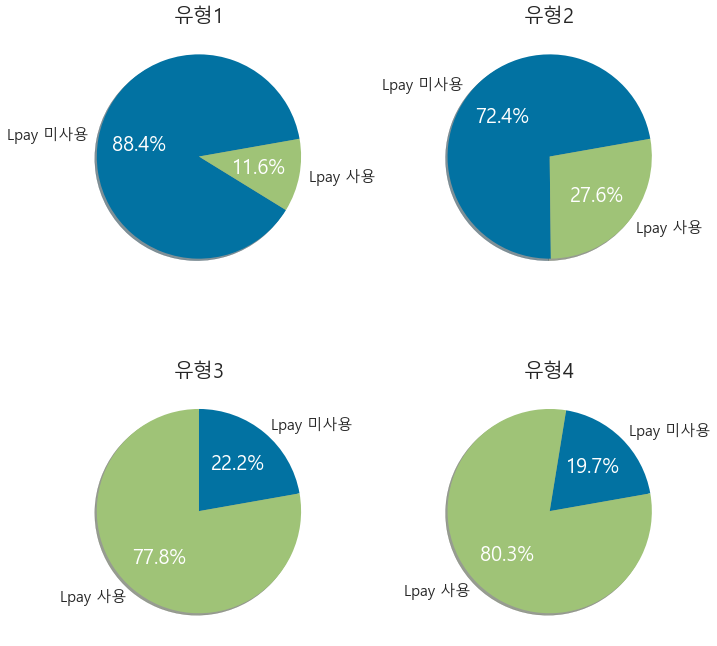

In [189]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
patches_0, texts_0, autotexts_0 = plt.pie(
    user[user['고객번호'].isin(customer_0)].groupby('Lpay이용여부').count().reset_index()['고객번호'],
    labels = ['Lpay 미사용', 'Lpay 사용'],
    labeldistance=1.1,## label이 파이로부터 얼마나 떨어지는가, 1일경우 딱 붙어있음. 
    startangle=10,## 어디에서 시작할지, 정해줌  
    shadow=True, ##그림자 
    autopct='%1.1f%%', ## pi 위에 표시될 글자 형태, 또한 알아서 %로 변환해서 알려줌 
)
plt.title('유형1', size = 20)

plt.subplot(2, 2, 2)
patches_1, texts_1, autotexts_1 = plt.pie(
    user[user['고객번호'].isin(customer_1)].groupby('Lpay이용여부').count().reset_index()['고객번호'],
    labels = ['Lpay 미사용', 'Lpay 사용'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형2', size = 20)

plt.subplot(2, 2, 3)
patches_2, texts_2, autotexts_2 = plt.pie(
    user[user['고객번호'].isin(customer_2)].groupby('Lpay이용여부').count().reset_index()['고객번호'],
    labels = ['Lpay 미사용', 'Lpay 사용'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형3', size = 20)

plt.subplot(2, 2, 4)
patches_3, texts_3, autotexts_3 = plt.pie(
    user[user['고객번호'].isin(customer_3)].groupby('Lpay이용여부').count().reset_index()['고객번호'],
    labels = ['Lpay 미사용', 'Lpay 사용'],
    labeldistance=1.1,
    startangle=10,
    shadow=True,
    autopct='%1.1f%%', 
)
plt.title('유형4', size = 20)

for t1, t2, t3, t4 in zip(autotexts_0, autotexts_1, autotexts_2, autotexts_3):
    t1.set_color("white")
    t1.set_fontsize(20)
    t2.set_color("white")
    t2.set_fontsize(20)
    t3.set_color("white")
    t3.set_fontsize(20)
    t4.set_color("white")
    t4.set_fontsize(20)

for t1,t2,t3,t4 in zip(texts_0, texts_1, texts_2, texts_3):
    t1.set_fontsize(15)
    t2.set_fontsize(15)
    t3.set_fontsize(15)
    t4.set_fontsize(15)
    
plt.tight_layout()
plt.show()

- -ing

## END